# Topic Modelling with `tfp` built-in Markov-Chain-Monte-Carlo Methods

### Settings

In [209]:
N_docs       = 300
sqrt_N_vocab = 3
N_words      = 50

ragged   = True
train_on = False
auto_batched = True

N_topics = int(2*sqrt_N_vocab)
N_vocab  = int(sqrt_N_vocab**2)

### Setup

In [210]:
import tensorflow_probability as tfp
import tensorflow as tf
tfd = tfp.distributions
tfb = tfp.bijectors
import numpy as np
from tqdm import tqdm

from timeit import timeit

np.random.seed(42)
tf.random.set_seed(42)

In [211]:
from importlib import reload  

import topicflow.utils  as tp_utils
import topicflow.data   as tp_data
import topicflow.models as tp_models

tp_utils  = reload(tp_utils)
tp_data   = reload(tp_data)
tp_models = reload(tp_models)

### Generating Data

In [212]:
if ragged:
    data = tp_data.squareLDDocuments(
        N_docs=N_docs, 
        sqrt_N_vocab=sqrt_N_vocab, 
        N_words_rate=N_words)

if not ragged:   
    data = tp_data.squareLDDocuments(
        N_docs=N_docs, 
        sqrt_N_vocab=sqrt_N_vocab, 
        N_words_fixed=N_words)


In [213]:
Theta, Pi, C_DId, C_DIdK, W_DId = data.extract_params()

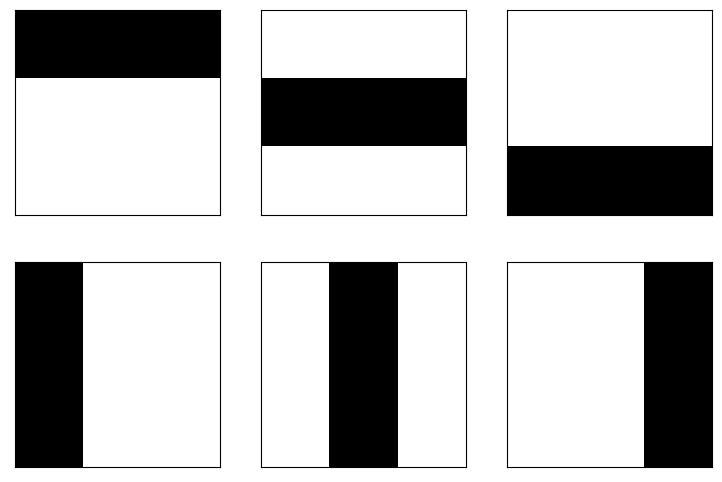

In [214]:
_ = tp_utils.visualize_topics(Theta, N_row=2, N_col=3)

## Inference

### Testing Behavior of `tfd.Sample(tfd.MixtureSameFamily(...))`

In [215]:
Pi_test = tf.one_hot(np.arange(0, N_topics), N_topics)
Pi_test.shape

TensorShape([6, 6])

In [216]:
test0 = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(
        probs=Pi_test
    ),
    components_distribution=tfd.Categorical(
        probs=Theta
    )
).sample(N_words)

In [217]:
tf.transpose(test0).shape

TensorShape([6, 50])

In [218]:
test1 = tfd.Sample(  
    tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(
            probs=Pi_test
        ),
        components_distribution=tfd.Categorical(
            probs=Theta
        )
    ),
    sample_shape=(N_words)
).sample()

In [219]:
test1.shape

TensorShape([6, 50])

Presenting documents [0 1 5 2 4 3]


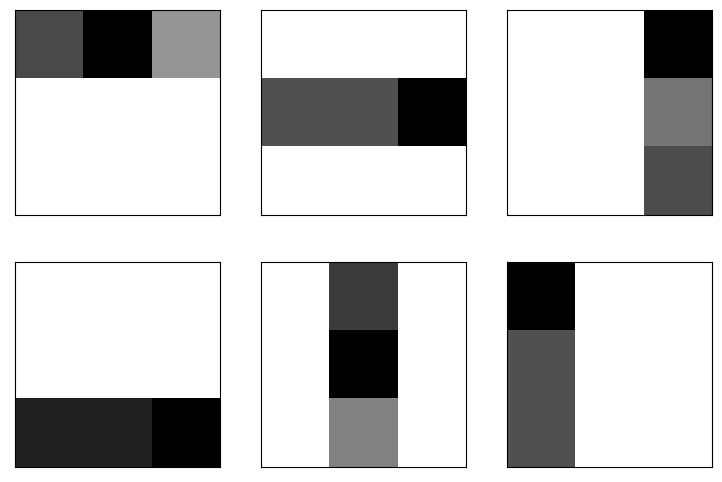

In [220]:
_ = tp_utils.visualize_random_docs(test1, sqrt_N_vocab, 2, 3, False)

### Preprocessing the Data

If the document length is variable, `tfp` methods are not properly applicable, because as of 2022-11-15 it lacks capabilities for processing `tf.RaggedTensor`'s. Thus no (joint)-distribution can be defined which samples variable-length documents. The idea is, to pad each document to the size of the longest document base on the observed frequency of each token in the document in a catrgorical-distributed manner:

$$
    X_{\textsf{pad}}^{(j)} \overset{\textsf{iid}}{\sim} \textsf{Categorcial}\left( \frac{\textsf{count}(x_i)}{\textsf{len}(\textsf{doc}_j)}; \ i =1,\dots, V \right)
$$

This should work becaus topic models are bag-of-words models where only the (relative) frequency of token occurances matter.

In [221]:
if ragged:
    pad_token = N_vocab + 1
    single_doclengths = W_DId.nested_row_lengths()[0].numpy()
    N_words = tf.reduce_max(single_doclengths)
    N_words_mean = tf.cast(tf.reduce_mean(single_doclengths), tf.float32)

    W_DId_ragged = W_DId.to_tensor(N_vocab+1).numpy()
    W_DId = []

    def pad_single_doc(doc, length, N_words_max=N_words):
        pad_size    = N_words_max - length
        doc_padded  = doc
        doc         = doc[doc != pad_token]
        idx, freq   = np.unique(doc, return_counts=True)
        freq        = freq / np.sum(freq)
        pad         = np.random.choice(idx, size=pad_size, p=freq)
        doc_padded[doc_padded == pad_token] = pad
        return doc_padded

    for doc, length in zip(W_DId_ragged, single_doclengths):
        W_DId.append(pad_single_doc(doc, length))
    
    W_DId = tf.constant(W_DId, dtype=tf.int32)

### Defining the Joint

Orientation was provided by https://www.tensorflow.org/probability/examples/A_Tour_of_TensorFlow_Probability. Let $V$ be the size of the vocabulary, $D$ be the number of documents, $N$ be the (maximum) document size and $K$ be the number of topics. In this toy model which provides practical visualization capabilities we have $\sqrt{V} \in \mathbb N$ and $K=2*\sqrt{V} \in \mathbb N$.

The Joint Model then is:
- Topic-Token prevalences (how much a topic "likes" a word): 
$$
    \Theta \sim \textsf{Dirichlet}(\beta) \qquad \Rightarrow \qquad \Theta \in \mathbb R^{K\times V}\ \ \textsf{such that} \ \ \sum_{v=1}^V \Theta_{kv} = 1\ \forall \ k\in \{1, \dots K\}\, .
$$
- Document-Topic prevalences (how much a document "likes" a topic):
$$
    \Pi \sim \textsf{Dirichlet}(\alpha)  \qquad \Rightarrow \qquad \Pi     \in \mathbb R^{D\times K}\ \ \textsf{such that} \ \ \sum_{k=1}^K \Pi_{dk}    = 1\ \forall \ d\in \{1, \dots D\}\, .
$$
- Topic-word assignments in each document (iid for all $N$ words in a document):
$$
    C \vert \Pi \sim \textsf{Categorical}(\Pi) \qquad \Rightarrow \qquad C \in \mathbb N^{D\times N}
$$ 
- Actual words in a document: $$P(w_{di}=v \vert c_{dik}, \Theta) = \prod_k \Theta_{kv}^{c_{dik}},$$ where $c_{dik}$ is one-hot encoded. This is equivalend to $$W \vert C, \Theta \sim \textsf{Categorical}(\texttt{tf.gather(} \Theta, C \texttt{)} )\, .$$

The "$C$-step" can be "integrated out" using `tfp`'s `MixtureSameFamily`-distribution-class (see for gaussian mixture model in https://www.tensorflow.org/probability/examples/Bayesian_Gaussian_Mixture_Model).

----------

`tfp` provides multiple ways of defining joints. We use 2 of them (choose by setting the `auto_bached` setting upfront).

#### Joint-Distribution auto-batched

This option enables us to define the joint only for one instance, i. e. one document

In [222]:
if auto_batched:

    ## Priors:
    alphas = tf.ones(N_topics,  dtype=tf.float32)
    betas  = tf.ones((N_topics, N_vocab), dtype=tf.float32)

    ## Joint
    @tfd.JointDistributionCoroutineAutoBatched
    def joint():
        Pi    = yield tfd.Dirichlet(alphas, name="Pi")
        Theta = yield tfd.Dirichlet(betas,  name="Theta")
        yield tfd.Sample(  
            tfd.MixtureSameFamily(
                mixture_distribution=tfd.Categorical(
                    probs=Pi
                ),
                components_distribution=tfd.Categorical(
                    probs=Theta
                )
            ),
            sample_shape=(N_words),
            name="W"
        )

    ## Sampling behavior 
    sample = joint.sample(N_docs)
    words = sample[-1]
    for key, val in zip(["Pi", "Theta", "W"], list(sample)):
        print(f"Sample Shape {key}: {val.shape}")

    ## Log-probability of observed (possibly padded data) assuming the joint
    p = joint.log_prob(W=W_DId, Pi=Pi, Theta=Theta).numpy()
    print(f"Log-Probability of the observed data: {np.sum(p)}")

Sample Shape Pi: (300, 6)
Sample Shape Theta: (300, 6, 9)
Sample Shape W: (300, 71)
Log-Probability of the observed data: -22868.83984375


#### "Classic" Joint Distribution:

Here we specify the whole joint distibution at once:

In [223]:
if not auto_batched:

    ## Priors:
    alphas = tf.ones((N_docs, N_topics),  dtype=tf.float32)
    betas  = tf.ones((N_topics, N_vocab), dtype=tf.float32)
            
    ## Joint
    joint = tfd.JointDistributionNamed(
        dict(
            Pi    = tfd.Dirichlet(alphas),
            Theta = tfd.Dirichlet(betas),
            W     = lambda Pi, Theta: tfd.Sample(  
                tfd.MixtureSameFamily(
                    mixture_distribution=tfd.Categorical(
                        probs=Pi
                    ),
                    components_distribution=tfd.Categorical(
                        probs=Theta
                    )
                ),
                sample_shape=(N_words)
            )
        ),
        batch_ndims=0,
        use_vectorized_map=True
    )

    ## Sampling behavior 
    sample = joint.sample()
    words = sample['W']
    for key, val in sample.items():
        print(f"Sample Shape {key}: {val.shape}")

    ## Log-probability of observed (possibly padded data) assuming the joint
    p = joint.log_prob(W=W_DId, Pi=Pi, Theta=Theta).numpy()
    print(f"Log-Probability of the observed data: {p}")

Presenting documents [ 75 130 207  20 134  58 123 213 295  80]


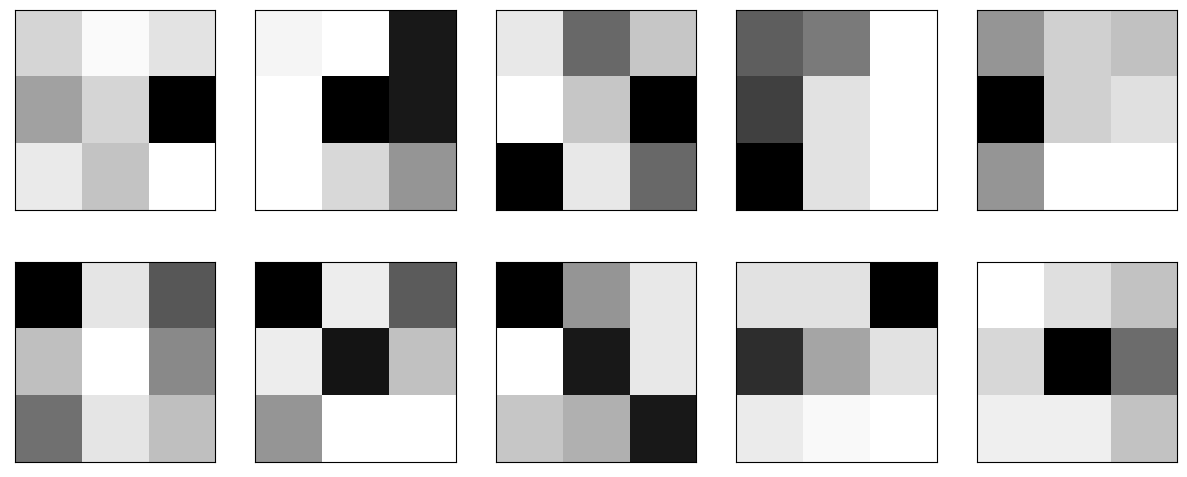

In [224]:
## Visualize documents from the prior-joint
_ = tp_utils.visualize_random_docs(words, sqrt_V=sqrt_N_vocab)

### Defining the unnormalized Posterior by introducing the Data:

In [225]:
if auto_batched:
    # Pin the observed `W_DId` values to model the un-normalized posterior.
    unnormalized_posterior_dist = joint.experimental_pin(W=W_DId)
    unnormalized_posterior = lambda Pi, Theta: tf.reduce_sum(unnormalized_posterior_dist.log_prob(Pi, Theta))

if not auto_batched:
    def unnormalized_posterior(Pi, Theta):
        return joint.log_prob(W=W_DId, Pi=Pi, Theta=Theta) # Incorporate data with W_DId

### HMC-Chain

In [226]:
## tf-magic
tf.config.experimental.enable_tensor_float_32_execution(False)

In [227]:
## Constraining the Dirichlet-Samples to discrete probability vectors
unconstraining_bijectors = [
    tfb.SoftmaxCentered(),
    tfb.SoftmaxCentered()
]

In [228]:
# Create an HMC TransitionKernel
kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_posterior,
            step_size=0.065,
            num_leapfrog_steps=5
        ),
    bijector=unconstraining_bijectors
    ),
    num_adaptation_steps=400
)

In [229]:
# We wrap sample_chain in tf.function, telling TF to precompile a reusable
# computation graph, which will dramatically improve performance.
@tf.function
def run_chain(initial_state, num_results=1000, num_burnin_steps=500):
    return tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        kernel=kernel,
        trace_fn=lambda _, pkr: pkr.inner_results.inner_results.is_accepted
    )

In [230]:
init_pis    = tf.ones_like(Pi, dtype=tf.float32)
init_thetas = tf.ones_like(Theta, dtype=tf.float32)
initial_state = [
    init_pis, 
    init_thetas
]

samples, is_accepted = run_chain(initial_state)

In [231]:
print("Acceptance rate:", tf.reduce_sum(tf.cast(is_accepted, dtype=tf.int16)/is_accepted.shape[0]).numpy())

Acceptance rate: 0.6249999


In [232]:
Pi_fit    = tf.reduce_mean(samples[0], axis=0)
Theta_fit = tf.reduce_mean(samples[1], axis=0)

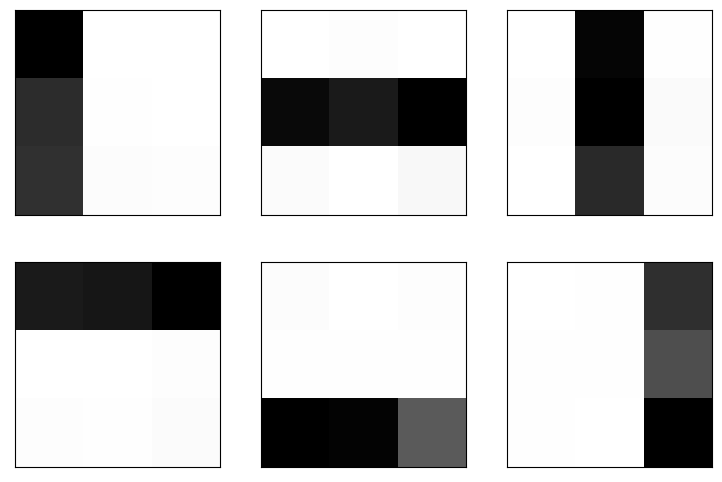

In [233]:
_ = tp_utils.visualize_topics(Theta_fit, N_row=2, N_col=3)

### Train on

Optional: Re-initialize the sampling loop using the results from the first run.

In [234]:
if train_on:
    initial_state = [
        Pi_fit, 
        Theta_fit
    ]
    samples, is_accepted = run_chain(initial_state)

    Pi_fit    = tf.reduce_mean(samples[0], axis=0)
    Theta_fit = tf.reduce_mean(samples[1], axis=0)
    _ = tp_utils.visualize_topics(samples[1][-1, :], N_row=2, N_col=3)